# Calculating 5-sigma Limiting Mag for LSST
___

## Rationale

This value is quoted in the opsim output, but it is being questioned. Understanding the derivation (and how to extract the image ZP) is important 

In [39]:
%matplotlib inline
# %matplotlib notebook

from __future__ import print_function

try:
    from importlib import reload
except:
    pass

import os
import sys
import warnings

import numpy as np
import pandas as pd
import astropy as ap
import sfdmap

import sqlite3
from sqlalchemy import create_engine

from collections import OrderedDict

from astropy.constants import h
from scipy.integrate import simps

from matplotlib import pyplot as plt
import matplotlib.colors as mpl_colors 

import astropy.units as u

In [2]:
import pyCoCo as pccsims
import pycoco as pcc

In [3]:
# %%timeit ## 1 loop, best of 3: 1min 31s per loop 
opsimdbpath = os.environ.get('OPSIMDBPATH')
print(opsimdbpath)
# opsimdbpath = "/Users/berto/data/LSST/OpSimOutputDBs/astro_lsst_01_1068_sqlite.db"
# opsimdbpath = "/Users/berto/data/LSST/OpSimOutputDBs/minion_1016_sqlite.db"

conn = create_engine('sqlite:///'+opsimdbpath, echo = False)
# opsimdf = pd.read_sql_table('Summary', con=conn)

/Users/berto/data/LSST/OpSimOutputDBs/minion_1016_sqlite.db


In [4]:
opsimdf = pd.read_sql_query(sql = "SELECT * FROM Summary WHERE night > 365 AND night < 731", con = conn)

opsimdf.columns

In [5]:
opsimdf.columns

Index(['obsHistID', 'sessionID', 'propID', 'fieldID', 'fieldRA', 'fieldDec',
       'filter', 'expDate', 'expMJD', 'night', 'visitTime', 'visitExpTime',
       'finRank', 'FWHMeff', 'FWHMgeom', 'transparency', 'airmass',
       'vSkyBright', 'filtSkyBrightness', 'rotSkyPos', 'rotTelPos', 'lst',
       'altitude', 'azimuth', 'dist2Moon', 'solarElong', 'moonRA', 'moonDec',
       'moonAlt', 'moonAZ', 'moonPhase', 'sunAlt', 'sunAz', 'phaseAngle',
       'rScatter', 'mieScatter', 'moonIllum', 'moonBright', 'darkBright',
       'rawSeeing', 'wind', 'humidity', 'slewDist', 'slewTime',
       'fiveSigmaDepth', 'ditheredRA', 'ditheredDec'],
      dtype='object')

# OpSim m5 derivation 
___
Recreating the m5 values, as per http://smtn-002.lsst.io/en/latest/

\begin{split}m5 = C_m + dC_m + 0.50\,(m_{sky} - 21.0) + 2.5 log_{10}(0.7 /
FWHM_{eff}) \\
+ 1.25 log_{10}(expTime / 30.0) - k_{atm}\,(X-1.0)\end{split}

\begin{split}dC_m = dC_m^{inf} - 1.25 log_{10}(1 + (10^{(0.8\, dC_m^{inf} -
1)}/Tscale)\end{split}

\begin{split}Tscale = expTime / 30.0 * 10.0^{-0.4*(m_{sky} - m_{darksky})}\end{split}


## $T_{\textrm{scale}}$
___
\begin{split}Tscale = expTime / 30.0 * 10.0^{-0.4*(m_{sky} - m_{darksky})}\end{split}
___
I need:

* exposure time
* sky brightness
* dark sky brightness

In [31]:
def calc_Tscale(df):
    """
    """
    Tscale = df["visitExpTime"].median()/30. * np.power(10., -0.4*(df["filtSkyBrightness"] - df["mdarksky"]))
    return Tscale

# def calc_Tscale_dict(df, m_sky_dict):
#     """
#     """
#     Tscale_dict = OrderedDict()
#     for filter_key in opsimdf["filter"].unique():
#         Tscale_dict[filter_key] = df["visitExpTime"].median()/30. * np.power(10., -0.4*(df["filtSkyBrightness"] - df["mdarksky"]))
#     return Tscale_dict

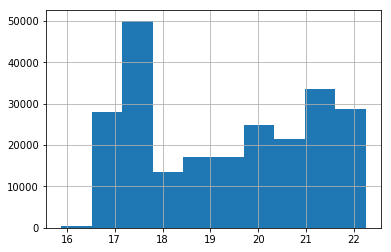

In [6]:
opsimdf["filtSkyBrightness"].hist()

In [14]:
dark_sky_path = os.path.join(os.environ["LSST_THROUGHPUTS_BASELINE"], "darksky.dat")
darksky = pcc.SpectrumClass()
darksky.load(dark_sky_path, wavelength_u=u.nm, flux_u=u.cgs.erg / u.si.cm ** 2 / u.si.s / u.nm,
             fmt="ascii.commented_header", wmin=3500 * u.angstrom, wmax=11000 * u.angstrom, )

lsst_filters = [i for i in opsimdf["filter"].unique()]

zp_dict = {}
m_sky_dict = {}

for filter_key in lsst_filters:
    zp_dict[filter_key] = pcc.kcorr.calc_AB_zp("LSST_"+filter_key)
    zp_dict["LSST_"+filter_key] = zp_dict[filter_key]
    
    m_sky_dict[filter_key] = -2.5 * np.log10(pcc.kcorr.calc_spectrum_filter_flux(filter_name="LSST_"+filter_key, spectrum_object=darksky)) - zp_dict[filter_key]
zp_dict   

{'LSST_g': 20.800353097326671,
 'LSST_i': 21.788562246399657,
 'LSST_r': 21.363924094544885,
 'LSST_u': 20.222025800474768,
 'LSST_y': 22.339399296798156,
 'LSST_z': 22.099349935088149,
 'g': 20.800353097326671,
 'i': 21.788562246399657,
 'r': 21.363924094544885,
 'u': 20.222025800474768,
 'y': 22.339399296798156,
 'z': 22.099349935088149}

In [17]:
m_sky_dict

{'g': 22.250868679171077,
 'i': 20.481708931523293,
 'r': 21.205508625835733,
 'u': 23.156864822544037,
 'y': 18.620467240176289,
 'z': 19.613198706158201}

In [18]:
opsimdf["zp"] = opsimdf["filter"].map(zp_dict)
opsimdf["mdarksky"] = opsimdf["filter"].map(m_sky_dict)

In [65]:
opsimdf.head(10)

,obsHistID,sessionID,propID,fieldID,fieldRA,fieldDec,filter,expDate,expMJD,night,...,ditheredDec,zp,mdarksky,Tscale,C_m,dC_m_inf,k_atm,dC_m,m5_calc,dm5
0,263142,1016,54,2061,0.000000,-0.219248,y,31625330,59946.033917,366,...,-0.209329,22.339399,18.620467,4.448227,23.71,0.02,0.18,0.007483,21.420686,0.027995
1,263143,1016,54,2067,0.053386,-0.218529,y,31625369,59946.034365,366,...,-0.208610,22.339399,18.620467,4.448227,23.71,0.02,0.18,0.007483,21.454623,0.027995
2,263144,1016,54,2085,0.106762,-0.216431,y,31625407,59946.034812,366,...,-0.206512,22.339399,18.620467,4.448227,23.71,0.02,0.18,0.007483,21.484381,0.027995
3,263145,1016,54,2202,0.080532,-0.171988,y,31625446,59946.035261,366,...,-0.162069,22.339399,18.620467,4.448227,23.71,0.02,0.18,0.007483,21.448220,0.027996
4,263146,1016,54,2212,0.134198,-0.169337,y,31625485,59946.035708,366,...,-0.159418,22.339399,18.620467,4.448227,23.71,0.02,0.18,0.007483,21.477537,0.027996
5,263147,1016,54,2226,0.187887,-0.165645,y,31625523,59946.036155,366,...,-0.155726,22.339399,18.620467,4.448227,23.71,0.02,0.18,0.007483,21.503323,0.027996
6,263148,1016,54,2234,0.241691,-0.161175,y,31625562,59946.036601,366,...,-0.151256,22.339399,18.620467,4.448227,23.71,0.02,0.18,0.007483,21.525988,0.027996
7,263149,1016,54,2244,0.295743,-0.156207,y,31625601,59946.037049,366,...,-0.146288,22.339399,18.620467,4.448227,23.71,0.02,0.18,0.007483,21.545878,0.027995
8,263150,1016,54,2136,0.321434,-0.198238,y,31625639,59946.037498,366,...,-0.188319,22.339399,18.620467,4.448227,23.71,0.02,0.18,0.007483,21.569981,0.027995
9,263151,1016,54,2144,0.376112,-0.192612,y,31625679,59946.037952,366,...,-0.182693,22.339399,18.620467,4.448227,23.71,0.02,0.18,0.007483,21.585879,0.027996


In [34]:
opsimdf["Tscale"] = calc_Tscale(opsimdf)

In [36]:
opsimdf["Tscale"].head()

0    4.448227
1    4.448227
2    4.448227
3    4.448227
4    4.448227
Name: Tscale, dtype: float64

## $dC_m$
___
\begin{split}dC_m = dC_m^{inf} - 1.25 log_{10}(1 + (10^{(0.8\, dC_m^{inf} -
1)}/Tscale)\end{split}

The $dC_m^{inf}$ term accounts for the transition between instrument noise limited observations and sky background limited observations as the exposure time or sky brightness varies. For most LSST bandpasses, we are sky-noise dominated even in 15 second exposures, but in the u band, the sky background is low enough that the exposures become read noise limited. The $ k_{atm}$ term captures the extinction of the atmosphere and how it varies with airmass. It can be calculated as $ k_{atm} =
-2.5 log_{10} (T_b / \Sigma_b)$, where $T_b$ is the sum of the total system throughput in a particular bandpass and $\Sigma_b$ is the sum of the hardware throughput in a particular bandpass (without the atmosphere).
___

<div class="wy-table-responsive"><div class="wy-table-responsive"><table border="1" class="docutils">
<colgroup>
<col width="25%">
<col width="25%">
<col width="29%">
<col width="21%">
</colgroup>
<tbody valign="top">
<tr class="row-odd"><td>Filter</td>
<td>$C_m$</td>
<td>$dC_m^{inf}$</td>
<td>$ k_{atm}$</td>
</tr>
<tr class="row-even"><td>u</td>
<td>22.91</td>
<td>0.57</td>
<td>0.50</td>
</tr>
<tr class="row-odd"><td>g</td>
<td>24.45</td>
<td>0.12</td>
<td>0.21</td>
</tr>
<tr class="row-even"><td>r</td>
<td>24.46</td>
<td>0.06</td>
<td>0.13</td>
</tr>
<tr class="row-odd"><td>i</td>
<td>24.33</td>
<td>0.05</td>
<td>0.10</td>
</tr>
<tr class="row-even"><td>z</td>
<td>24.17</td>
<td>0.03</td>
<td>0.07</td>
</tr>
<tr class="row-odd"><td>y</td>
<td>23.71</td>
<td>0.02</td>
<td>0.18</td>
</tr>
</tbody>
</div>
___

Initially, use the tabulated values

In [45]:
filter_shortname = ["u","g","r","i","z","y"]
filter_name = ["LSST_"+ i for i in filter_shortname]
C_m = [22.91,24.45,24.46,24.33,24.17,23.71]
dC_m_inf = [0.57,0.12,0.06,0.05,0.03,0.02]
k_atm = [0.50,0.21,0.13,0.10,0.07,0.18]

C_m_dict = OrderedDict()
dC_m_inf_dict = OrderedDict()
k_atm_dict = OrderedDict()

for i, filter_key in enumerate(filter_shortname):
    C_m_dict[filter_key] = C_m[i]
    dC_m_inf_dict[filter_key] = dC_m_inf[i]
    k_atm_dict[filter_key] = k_atm[i]

In [46]:
opsimdf["C_m"] = opsimdf["filter"].map(C_m_dict)
opsimdf["dC_m_inf"] = opsimdf["filter"].map(dC_m_inf_dict)
opsimdf["k_atm"] = opsimdf["filter"].map(k_atm_dict)

In [47]:
opsimdf.columns

Index(['obsHistID', 'sessionID', 'propID', 'fieldID', 'fieldRA', 'fieldDec',
       'filter', 'expDate', 'expMJD', 'night', 'visitTime', 'visitExpTime',
       'finRank', 'FWHMeff', 'FWHMgeom', 'transparency', 'airmass',
       'vSkyBright', 'filtSkyBrightness', 'rotSkyPos', 'rotTelPos', 'lst',
       'altitude', 'azimuth', 'dist2Moon', 'solarElong', 'moonRA', 'moonDec',
       'moonAlt', 'moonAZ', 'moonPhase', 'sunAlt', 'sunAz', 'phaseAngle',
       'rScatter', 'mieScatter', 'moonIllum', 'moonBright', 'darkBright',
       'rawSeeing', 'wind', 'humidity', 'slewDist', 'slewTime',
       'fiveSigmaDepth', 'ditheredRA', 'ditheredDec', 'zp', 'mdarksky',
       'Tscale', 'C_m', 'dC_m_inf', 'k_atm'],
      dtype='object')

In [52]:
def calc_dC_m(df):
    dC_m = df["dC_m_inf"] - 1.25*np.log10(1.+np.power(10., 0.8*df["dC_m_inf"] - 1.)/df["Tscale"])
    return dC_m

In [53]:
opsimdf["dC_m"] = calc_dC_m(opsimdf)

## m5
___
\begin{split}m5 = C_m + dC_m + 0.50\,(m_{sky} - 21.0) + 2.5 log_{10}(0.7 /
FWHM_{eff}) \\
+ 1.25 log_{10}(expTime / 30.0) - k_{atm}\,(X-1.0)\end{split}

In [55]:
def calc_m5(df):
    m5 = df["C_m"] + df["dC_m"] + 0.5*(df["filtSkyBrightness"] - 21.0) + 2.5*np.log10(0.7/df["FWHMeff"])+1.25*np.log10(df["visitExpTime"]/30.0) - df["k_atm"]*(df["airmass"]-1.0)
    return m5

In [57]:
opsimdf["m5_calc"] = calc_m5(opsimdf)

In [63]:
opsimdf["dm5"] = opsimdf["fiveSigmaDepth"]-opsimdf["m5_calc"]

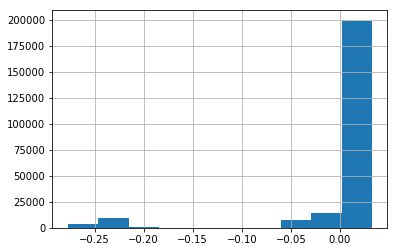

In [64]:
opsimdf["dm5"].hist()

## Summary
___

I'm calculating a slightly _brighter_ m5 - this is probably due to using tabulated values rather than calculating them from scratch.
